# **Descarga del dataset**

In [ ]:
import kagglehub

# Download latest version
path5 = kagglehub.dataset_download("ujjwalchowdhury/energy-efficiency-data-set")

print("Path to dataset files:", path5)

Path to dataset files: /kaggle/input/energy-efficiency-data-set


# **Parte 1 - Reducción de dimensionalidad (solo pre-procesamiento)**

El objetivo es realizar una reducción de dimensionalidad a través de PCA con 2 componentes. Esto con la intención de poder mostrar por qué la reducción no siempre es necesaria.

Se utilizará el dataset Energy Efficiency el cual son datos obtenidos de simulaciones en Ecotect para 12 tipos de edificios con distintas características, entre las que se encuentran: Orientación, Envidriado, Formas arquitectónicas, etc. Posee 768 muestras con 8 variables de entrada. Las varaibles objetivos del dataset son Heating Load y Cooling Load.

Partiremos cargando las librerias necesarias para la reducción.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Cargaremos el dataset y visualicemos las primeras 5 filas, para ver su estructura.

In [ ]:
df5 = pd.read_csv(path5 + '/energy_efficiency_data.csv')
df5.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Veamos si el dataset posee nulos, y de ser así, procederemos a arreglarlos.

In [ ]:
df5.isnull().sum()

,0
Relative_Compactness,0
Surface_Area,0
Wall_Area,0
Roof_Area,0
Overall_Height,0
Orientation,0
Glazing_Area,0
Glazing_Area_Distribution,0
Heating_Load,0
Cooling_Load,0


Como las últimas dos variables son de objetivo, las eliminaremos para realizar la reducción.

In [ ]:
df5 = df5.drop(columns=['Cooling_Load', 'Heating_Load'])

Como vimos anteriormente, PCA es sensible a la dimensionalidad, por lo que procederemos a estandarizar los datos.


In [ ]:
scaler = StandardScaler()
X_scaled_5 = scaler.fit_transform(df5)

Ahora, aplicaremos el método PCA con reducción a 2 componentes y veremos cuánta es la varianza que explican.

In [ ]:
pca = PCA(n_components=2)
X_pca_5 = pca.fit_transform(X_scaled_5)

varianza_5 = pca.explained_variance_ratio_
sum(varianza_5)

np.float64(0.6178488249883751)

Notemos que la varianza explicada por las dos componentes no es mayor o igual a 90%, sino que solo retiene aproximadamente el 62% de la varianza.



Veamos cuántas componentes son necesarias para abarcar un 90% o más de la varianza.

In [ ]:
pca = PCA(n_components=0.9)
X_pca_90 = pca.fit_transform(X_scaled_5)

X_pca_90.shape

(768, 5)

Como podemos notar, hacen falta 5 componentes para obtener una varianza
explicada acumulada mayor a 90% por lo que en este caso no resulta una
ventaja aplicar PCA con pocas componentes.

Veamos un gráfico de barra para ver cuanta es la varianza que van explicando las componentes.


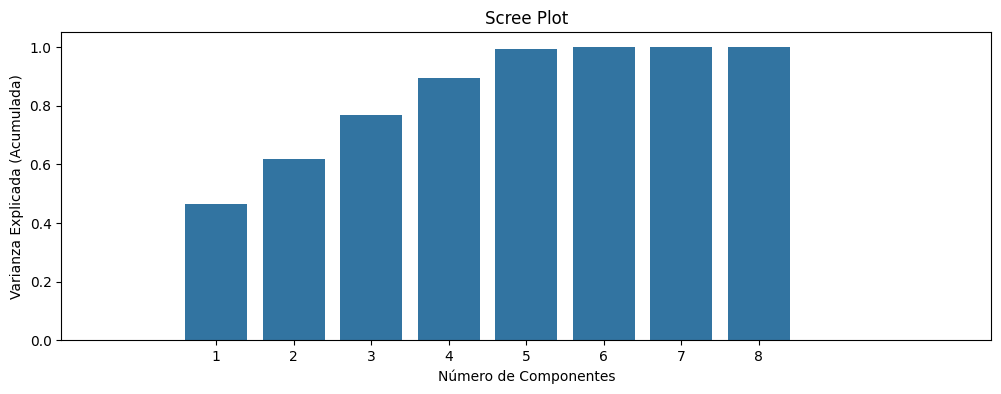

In [ ]:
pca = PCA()
X_pca_acum = pca.fit_transform(X_scaled_5)

varianza_acum = pca.explained_variance_ratio_

x = np.arange(1, len(varianza_acum) + 1)

plt.figure(figsize=(12, 4))
sns.barplot(x=x,y=np.cumsum(varianza_acum))
plt.xlim(-2,10)
plt.title('Scree Plot')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada (Acumulada)')
plt.grid(False)
plt.show()

Por lo tanto podemos concluir que en este caso realizar una reduccion a una dimensionalidad baja no representa una ventaja, debido a que la varianza explicada por ellas no es suficientemente alta.
 Se observa que desde la quinta componente la varianza explicada comienza a ser mayor que 90%, pero el dataset cuenta con solo 8 variables, lo cual evidencia lo mencionado anteriormente.

# **Parte 2 - Modelado sobre datos en bruto y reducidos**

El objetivo es aplicar los modelos supervisados Linear Regresion (Ridge) y Random Forest con y sin PCA para comparar sus rendimientos y utilidades.

Partamos cargando todas las librerías necesarias para los modelos y el dataset correspondiente.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df5 = pd.read_csv(path5 + '/energy_efficiency_data.csv')

Ahora procedemos a hacer la separación de los datos entre datos de entrenamiento y datos de testeo. A la variable X le entregamos las características y a y le damos la variables objetivo.

In [ ]:
X = df5.drop(columns=['Heating_Load','Cooling_Load'])
y = df5[['Heating_Load','Cooling_Load']]

Procedamos a hacer el split de las variables

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

Definamos las métricas para evaluar las predicciones

In [ ]:
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

## **Modelo 1: Linear Regression**

Sin reducción PCA:

In [ ]:
lin = Pipeline([("scaler",StandardScaler()),("lr",LinearRegression())])
lin.fit(X_tr,y_tr)
pred = lin.predict(X_te)

def rmse(a,b): return np.sqrt(mean_squared_error(a,b))
print("MAE :", mean_absolute_error(y_te,pred))
print("RMSE:", rmse(y_te,pred))
print("R²  :", r2_score(y_te,pred))

MAE : 2.1886711163218973
RMSE: 3.085985701777215
R²  : 0.90270481100771


Con reducción PCA:

In [ ]:
lin = Pipeline([("scaler",StandardScaler()),('pca',PCA(n_components=2)),("lr",LinearRegression())])
lin.fit(X_tr,y_tr)
pred = lin.predict(X_te)

def rmse(a,b): return np.sqrt(mean_squared_error(a,b))
print("MAE :", mean_absolute_error(y_te,pred))
print("RMSE:", rmse(y_te,pred))
print("R²  :", r2_score(y_te,pred))

MAE : 4.112808763036296
RMSE: 5.439690859862244
R²  : 0.6997654865319418


## **Modelo 2: Ridge**

En este escenario se ajustarán 3 modelos de Regresión Ridge para cada caso, donde el hiperparámetro de regularización tomará 3 valores distinto en cada modelo (0.01, 0.1, 10.0). Esto con el objeto de posteriormente hacer una comparación de estos modelos a traves de las metricas de desempeño (error cuadrático medio, coeficiente R^2, etc).

Sin reducción PCA:

In [ ]:
for Model, name in [(Ridge(alpha=0.1), "Ridge 0.1"),
                    (Ridge(alpha=0.01), "Ridge 0.01"),
                    (Ridge(alpha=10.0), "Ridge 10.0")
                    ]:
    mdl = Pipeline([("scaler", StandardScaler()), ("reg", Model)])
    mdl.fit(X_tr, y_tr)
    y_pred = mdl.predict(X_te)
    print(name,
          "MAE:", mean_absolute_error(y_te,y_pred),
          "RMSE:", rmse(y_te,y_pred),
          "R²:",  r2_score(y_te,y_pred))

Ridge 0.1 MAE: 2.188875779478026 RMSE: 3.086619219448549 R²: 0.9026660298509767
Ridge 0.01 MAE: 2.1886860875773344 RMSE: 3.086045379547296 R²: 0.9027011727988634
Ridge 10.0 MAE: 2.249852816144561 RMSE: 3.1825223007799845 R²: 0.8964941962369691


Con reducción PCA:

In [ ]:
for Model, name in [(Ridge(alpha=0.1), "Ridge 0.1"),
                    (Ridge(alpha=0.01), "Ridge 0.01"),
                    (Ridge(alpha=10.0), "Ridge 10.0")
                    ]:
    mdl = Pipeline([("scaler", StandardScaler()),
                    ("pca", PCA(n_components=2)),
                    ("reg", Model)])
    mdl.fit(X_tr, y_tr)
    y_pred = mdl.predict(X_te)
    print(name,
          "MAE:", mean_absolute_error(y_te,y_pred),
          "RMSE:", rmse(y_te,y_pred),
          "R²:",  r2_score(y_te,y_pred))

Ridge 0.1 MAE: 4.112848350595264 RMSE: 5.439709981944648 R²: 0.6997633839672558
Ridge 0.01 MAE: 4.112812722231064 RMSE: 5.439692770493772 R²: 0.6997652764504296
Ridge 10.0 MAE: 4.116858372749518 RMSE: 5.441773529995797 R²: 0.6995363076259553


## **Modelo 3: Random Forest**

En este modelo de regresion "Random Forest" consideraremos 300 arboles en el bosque para mejorar la estabilidad y precisión del modelo. Además no consideraremos un limite fijo en la profundidad del árbol.

Sin reducción PCA:

In [ ]:
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf",   RandomForestRegressor(
                n_estimators=300,
                max_depth=None,
                random_state=42,
                oob_score=True))
])

Entrenamiento

In [ ]:
rf_pipe.fit(X_tr, y_tr)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(n_estimators=300, oob_score=True,
                                       random_state=42))])

Predicción

In [ ]:
y_pred_rf = rf_pipe.predict(X_te)

Métricas

In [ ]:
print("MAE :", mean_absolute_error(y_te,y_pred_rf))
print("RMSE:", rmse(y_te,y_pred_rf))
print("R²  :", r2_score(y_te,y_pred_rf))

MAE : 0.7586557359307313
RMSE: 1.40965991829039
R²  : 0.9786990405943846


Con reducción PCA:

In [ ]:
rf_pipe_pca = Pipeline([
    ("scaler", StandardScaler()),
    ('pca',PCA(n_components=2)),
    ("rf",   RandomForestRegressor(
                n_estimators=300,
                max_depth=None,
                random_state=42,
                oob_score=True))
])

Entrenamiento

In [ ]:
rf_pipe_pca.fit(X_tr, y_tr)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('rf',
                 RandomForestRegressor(n_estimators=300, oob_score=True,
                                       random_state=42))])

Predicción

In [ ]:
y_pred_rf_pca = rf_pipe_pca.predict(X_te)

Métricas

In [ ]:
print("MAE :", mean_absolute_error(y_te,y_pred_rf_pca))
print("RMSE:", rmse(y_te,y_pred_rf_pca))
print("R²  :", r2_score(y_te,y_pred_rf_pca))

MAE : 1.161245562770566
RMSE: 1.7280429367187546
R²  : 0.9686829318425514


## Tabla Comparativa de Modelos

| Modelo                      | Reducción | MAE    | RMSE   | R²     | Tiempo de Ejecución |
|-----------------------------|-----------|--------|--------|--------|---------------------|
| Linear Regression           | Sin PCA   | 2.189  | 3.086  | 0.903  |     4 µs                |
| Linear Regression           | Con PCA   | 4.113  | 5.440  | 0.700  |   16 µs                  |
| Ridge (alpha=0.1)           | Sin PCA   | 2.189  | 3.087  | 0.903  |    11 µs                 |
| Ridge (alpha=0.01)          | Sin PCA   | 2.189  | 3.086  | 0.903  |     8 µs                |
| Ridge (alpha=10.0)          | Sin PCA   | 2.250  | 3.183  | 0.896  |    15 ms                  |
| Ridge (alpha=0.1)           | Con PCA   | 4.113  | 5.440  | 0.700  |       14.3 ms               |
| Ridge (alpha=0.01)          | Con PCA   | 4.113  | 5.440  | 0.700  |      11.4 ms               |
| Ridge (alpha=10.0)          | Con PCA   | 4.117  | 5.442  | 0.700  |     11.89 ms                |
| Random Forest               | Sin PCA   | 0.759  | 1.410  | 0.979  |       1.89 s                       |
| Random Forest               | Con PCA   | 1.161  | 1.728  | 0.969  |         1.64 s             |

Notemos que la reducción de dimensionalidad a dos componentes mediante PCA provocó una caida notable en el desempeño de los modelos de regresión, puesto que se observa un aumento considerable en las métricas de error MAE y RMSE. Esto valida la conclusión de la Parte 1 de que 2 componentes no son suficientes para representar adecuadamente la variabilidad en los datos.


El modelo Random Forest, al ser un modelo no lineal basado en árboles de decisión, fue capaz de capturar las relaciones complejas entre las 8 características originales y las cargas energéticas, logrando una predicción muy precisa sin necesidad de reducción. Los modelos lineales tuvieron un rendimiento respetable sin reducción, pero palidecieron en comparación con Random Forest.

Entre los modelos lineales, Ridge tuvo un rendimiento muy similar a la Regresión Lineal estándar, con pequeñas variaciones dependiendo del parámetro alpha.

Por último Random Forest sin reducción PCA fue claramente el mejor modelo para este ejercicio, logrando el menor error y el mayor R².